# Weight and mix

In [2]:
import sys
sys.path.append('/Users/kenzatazi/Documents/CDT/Code/bcm4rcm')

In [3]:
import numpy as np
import xarray as xr
import glob
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cf
import matplotlib.ticker as mticker
import utils.areal_plots as aplot
import utils.prob_plots as pplot

In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
#set plot font size
plt.rcParams.update({'font.size': 16})

## Calculate weights

In [6]:
# pass the wassertein distance to softmax function

wass = np.load('/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/weights/wass_arr.npy')

In [7]:
wass.shape

(5, 12, 90, 40, 1)

In [8]:
T = 8  # temperature

In [9]:
def softmax(wass:np.array, T:int=8)-> np.array:
    """
    Generate weights for each model.

    Args:
        wass (np.array): Wasserstain-2 distances
        T (int, optional): temperature, the higher the temperature the more likely RCMs are to each other. Defaults to 8. 

    Returns:
        np.array: weights for each model
    """
    weights = np.exp(wass / T)
    # take weights for each model and normalise them by the sum of all weights
    weight_sum = np.sum(weights, axis=0)
    weights_norm = weights / weight_sum
    return weights_norm


In [10]:
weights = softmax(wass, T)

In [11]:
weights = weights.reshape(5, 12, 90, 40)

In [12]:
def mixture_of_experts(weights:np.array, model_outputs:np.array)-> np.array:
    """
    Generate mixture of experts.

    Args:
        weights (np.array): weights for each model
        model_outputs (np.array): model outputs

    Returns:
        np.array: mixture of experts mean
    """
    mean = np.sum(weights * model_outputs, axis=0)
    return mean

## Historical predictions

In [13]:
rcm_list = []

for file in glob.glob('/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/historical*.csv'):
    print(file)
    df = pd.read_csv(file, index_col=0)
    loc_df =  df

    loc_df['time'] = pd.to_datetime(loc_df['time'])
    loc_df['month'] = loc_df['time'].dt.month
    loc_df = loc_df.sort_values(by=['month', 'lon', 'lat'])
    
    #p95 = np.percentile(loc_df['tp'], 95)
    loc_df['tp_scale'] = loc_df['tp']
    
    loc_df_gr = loc_df.groupby(['month', 'lon', 'lat']).mean().reset_index()

    rcm_list.append(loc_df_gr[['month', 'lon', 'lat', 'tp_scale']].values.reshape(12, 90, 40, 4))

/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/historical_MPI-REMO2009_1976_2006.csv
/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/historical_CSIRO_1976_2006.csv
/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/historical_MPI_IITM_1976_2006.csv
/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/historical_NOAA_SMHI1976_2006.csv
/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/historical_MIROC_1976_2006.csv


In [14]:
rcm_stack = np.stack(rcm_list, axis=0)

In [15]:
mix_exp = mixture_of_experts(weights, rcm_stack[:,:,:,:, 3])

In [16]:
np.save('historical_mix_exp_T8.npy', mix_exp)

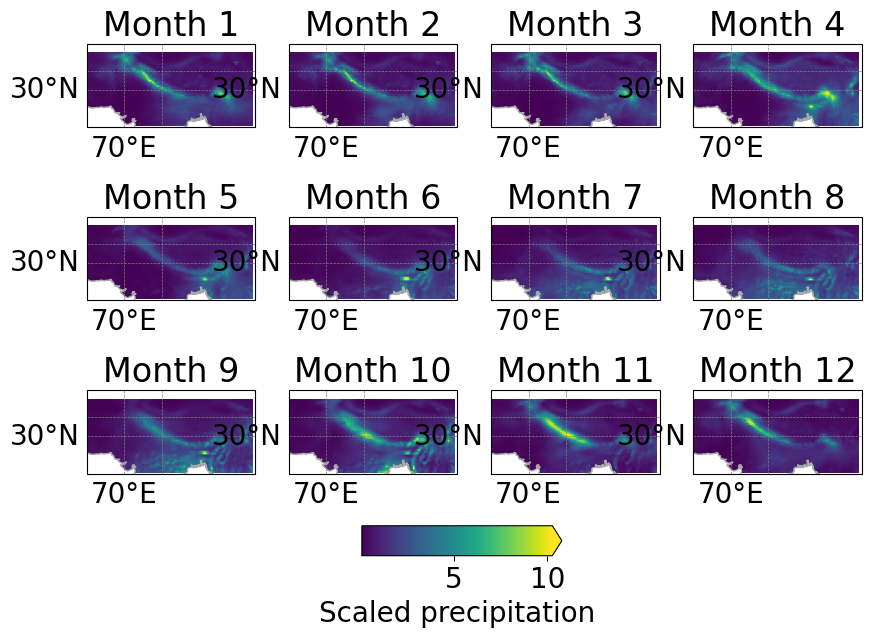

In [17]:
# plot outputs

proj= ccrs.PlateCarree()
fig, ax = plt.subplots(3, 4, figsize=(10, 6), sharey=True, sharex=True, subplot_kw=dict(projection=proj))

# Map
land_50m = cf.NaturalEarthFeature(
    "physical", "land", "50m", edgecolor="darkgrey", facecolor='whitesmoke',)
ocean_50m = cf.NaturalEarthFeature(
    "physical", "ocean", "50m", edgecolor="darkgrey", facecolor='white')

for i in range(12):
    #ax[i, 0].set_ylabel('RCM {}'.format(i+1), labelpad=20)
    ax[i//4, i%4].set_title('Month {}'.format(i+1))
    ax[i//4, i%4].add_feature(ocean_50m)
    ax[i//4, i%4].set_extent([60, 105, 20, 40])
    im = ax[i//4, i%4].imshow(np.swapaxes(mix_exp[i], axis1=0, axis2=1), extent=(60.25, 104.25, 20.25, 40),
                            origin='lower', cmap='viridis')

    gl = ax[i//4, i%4].gridlines(draw_labels=True, linewidth=0.5, linestyle='--', color='gray')
    gl.xlocator = mticker.FixedLocator([70, 80])
    gl.ylocator = mticker.FixedLocator([30, 35])
    gl.top_labels = False
    gl.right_labels = False

# change vertical spacing between subplots
fig.subplots_adjust(hspace=0.5)
cbar_ax = fig.add_axes([0.4, 0, 0.2, 0.05])
fig.colorbar(im, cax=cbar_ax, orientation='horizontal', label='Scaled precipitation', extend='max')
#plt.savefig('w', bbox_inches='tight')

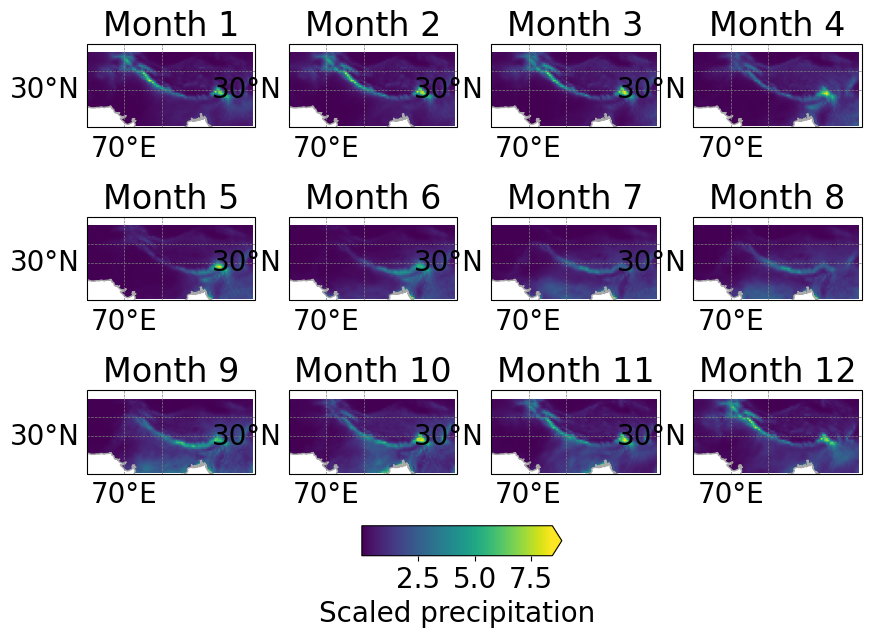

In [18]:
proj= ccrs.PlateCarree()
fig, ax = plt.subplots(3, 4, figsize=(10, 6), sharey=True, sharex=True, subplot_kw=dict(projection=proj))

# Map
land_50m = cf.NaturalEarthFeature(
    "physical", "land", "50m", edgecolor="darkgrey", facecolor='whitesmoke',)
ocean_50m = cf.NaturalEarthFeature(
    "physical", "ocean", "50m", edgecolor="darkgrey", facecolor='white')

for i in range(12):
    #ax[i, 0].set_ylabel('RCM {}'.format(i+1), labelpad=20)
    ax[i//4, i%4].set_title('Month {}'.format(i+1))
    ax[i//4, i%4].add_feature(ocean_50m)
    ax[i//4, i%4].set_extent([60, 105, 20, 40])
    im = ax[i//4, i%4].imshow(np.swapaxes(rcm_stack[0, i, :, :, 3], axis1=0, axis2=1), extent=(60.25, 104.25, 20.25, 40),
                            origin='lower', cmap='viridis')

    gl = ax[i//4, i%4].gridlines(draw_labels=True, linewidth=0.5, linestyle='--', color='gray')
    gl.xlocator = mticker.FixedLocator([70, 80])
    gl.ylocator = mticker.FixedLocator([30, 35])
    gl.top_labels = False
    gl.right_labels = False

# change vertical spacing between subplots
fig.subplots_adjust(hspace=0.5)
cbar_ax = fig.add_axes([0.4, 0, 0.2, 0.05])
fig.colorbar(im, cax=cbar_ax, orientation='horizontal', label='Scaled precipitation', extend='max')
#plt.savefig('w', bbox_inches='tight')

In [19]:
historical_ds = xr.Dataset(data_vars=dict(y_pred=(["time", "lon", "lat"], mix_exp)),
                           coords=dict(lon =('lon', np.arange(60.25, 105, 0.5)),
                                        lat =('lat', np.arange(20.25, 40, 0.5)),
                                        time = ('time', np.arange(1, 13, 1))))
historical_ds

<xarray.Dataset>
Dimensions:  (time: 12, lon: 90, lat: 40)
Coordinates:
  * lon      (lon) float64 60.25 60.75 61.25 61.75 ... 103.2 103.8 104.2 104.8
  * lat      (lat) float64 20.25 20.75 21.25 21.75 ... 38.25 38.75 39.25 39.75
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    y_pred   (time, lon, lat) float64 0.3231 0.2602 0.2513 ... 0.2343 0.274

## Far-future predictions

### RCP 8.5

In [20]:
## RCP 8.5 FF

rcp85_ff_rcm_list = []

for file in glob.glob('/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/rcp85*95.csv'):
    print(file)
    df = pd.read_csv(file, index_col=0)
    loc_df =  df

    loc_df['time'] = pd.to_datetime(loc_df['time'])
    loc_df['month'] = loc_df['time'].dt.month
    loc_df = loc_df.sort_values(by=['month', 'lon', 'lat'])
    
    loc_df['tp_scale'] = loc_df['tp']
    
    loc_df_gr = loc_df.groupby(['month', 'lon', 'lat']).mean().reset_index()
    rcp85_ff_rcm_list.append(loc_df_gr[['month', 'lon', 'lat', 'tp_scale']].values.reshape(12, 90, 40, 4))

/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/rcp85_CSIRO_2066_2095.csv
/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/rcp85_NOAA_SMHI_2066_2095.csv
/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/rcp85_MPI-REMO2009_2066_2095.csv
/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/rcp85_MPI_IITM_2066_2095.csv
/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/rcp85_MIROC_2066_2095.csv


In [21]:
rcp85_ff_stack = np.stack(rcp85_ff_rcm_list, axis=0)

In [22]:
mix_exp_rcp85_ff = mixture_of_experts(weights, rcp85_ff_stack[:,:,:,:, 3])

In [23]:
np.save('rcp85_ff_mix_exp_T8.npy', mix_exp_rcp85_ff)

In [24]:
rcp85_ff_ds = xr.Dataset(data_vars=dict(y_pred=(["time", "lon", "lat"], mix_exp_rcp85_ff)),
                           coords=dict(lon =('lon', np.arange(60.25, 105, 0.5)),
                                        lat =('lat', np.arange(20.25, 40, 0.5)),
                                        time = ('time', np.arange(1, 13, 1))))
rcp85_ff_ds

<xarray.Dataset>
Dimensions:  (time: 12, lon: 90, lat: 40)
Coordinates:
  * lon      (lon) float64 60.25 60.75 61.25 61.75 ... 103.2 103.8 104.2 104.8
  * lat      (lat) float64 20.25 20.75 21.25 21.75 ... 38.25 38.75 39.25 39.75
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    y_pred   (time, lon, lat) float64 0.2572 0.3082 0.3183 ... 0.2018 0.1863

### RCP 4.5

In [25]:
## RCP 8.5 FF

rcp45_ff_rcm_list = []

for file in glob.glob('/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/rcp45*95.csv'):
    print(file)
    df = pd.read_csv(file, index_col=0)
    loc_df =  df

    loc_df['time'] = pd.to_datetime(loc_df['time'])
    loc_df['month'] = loc_df['time'].dt.month
    loc_df = loc_df.sort_values(by=['month', 'lon', 'lat'])
    
    loc_df['tp_scale'] = loc_df['tp']
    
    loc_df_gr = loc_df.groupby(['month', 'lon', 'lat']).mean().reset_index()
    rcp45_ff_rcm_list.append(loc_df_gr[['month', 'lon', 'lat', 'tp_scale']].values.reshape(12, 90, 40, 4))

/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/rcp45_MIROC_2066_2095.csv
/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/rcp45_MPI-REMO2009_2066_2095.csv
/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/rcp45_NOAA_SMHI_2066_2095.csv
/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/rcp45_MPI_IITM_2066_2095.csv
/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/rcp45_CSIRO_2066_2095.csv


In [26]:
rcp45_ff_stack = np.stack(rcp45_ff_rcm_list, axis=0)

In [27]:
mix_exp_rcp45_ff = mixture_of_experts(weights, rcp45_ff_stack[:,:,:,:, 3])

In [28]:
np.save('rcp45_ff_mix_exp_T8.npy', mix_exp_rcp45_ff)

In [29]:
rcp45_ff_ds = xr.Dataset(data_vars=dict(y_pred=(["time", "lon", "lat"], mix_exp_rcp45_ff)),
                           coords=dict(lon =('lon', np.arange(60.25, 105, 0.5)),
                                        lat =('lat', np.arange(20.25, 40, 0.5)),
                                        time = ('time', np.arange(1, 13, 1))))
rcp45_ff_ds

<xarray.Dataset>
Dimensions:  (time: 12, lon: 90, lat: 40)
Coordinates:
  * lon      (lon) float64 60.25 60.75 61.25 61.75 ... 103.2 103.8 104.2 104.8
  * lat      (lat) float64 20.25 20.75 21.25 21.75 ... 38.25 38.75 39.25 39.75
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    y_pred   (time, lon, lat) float64 0.1026 0.1213 0.1242 ... 0.05868 0.07193

### Plots

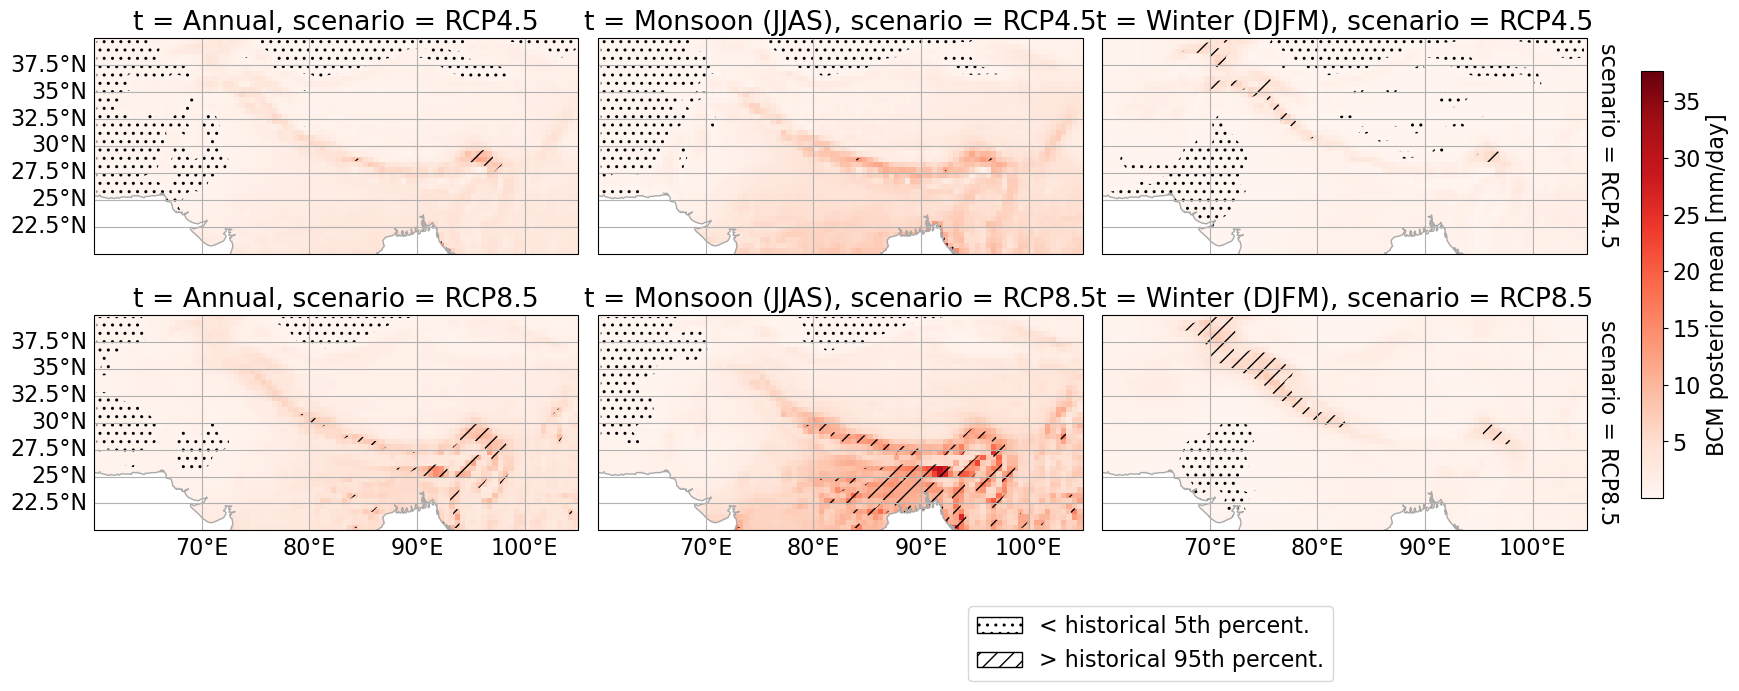

In [52]:
aplot.scenario_plot(historical_ds, rcp45_ff_ds, rcp85_ff_ds, cmap='Reds')
plt.savefig('scenario_ff_difference.pdf', bbox_inches='tight')

In [49]:
ds_ff = xr.concat([historical_ds, rcp45_ff_ds, rcp85_ff_ds], dim='scenario')
df_ff = ds_ff.to_dataframe()
df_ff = df_ff.unstack('scenario')
df_ff.columns = df_ff.columns.droplevel(0)
df_ff.reset_index(inplace=True)
df_ff.rename(columns={0:'historical', 1:'RCP4.5', 2:'RCP8.5'}, inplace=True)
df_ff

scenario,time,lon,lat,historical,RCP4.5,RCP8.5
0,1,60.25,20.25,0.323148,0.102558,0.257207
1,1,60.25,20.75,0.260154,0.121294,0.308238
2,1,60.25,21.25,0.251318,0.124155,0.318261
3,1,60.25,21.75,0.218724,0.120061,0.406204
4,1,60.25,22.25,0.185323,0.136544,0.490079
...,...,...,...,...,...,...
43195,12,104.75,37.75,0.235142,0.069624,0.243755
43196,12,104.75,38.25,0.239123,0.065448,0.228369
43197,12,104.75,38.75,0.229534,0.064814,0.218521
43198,12,104.75,39.25,0.234260,0.058675,0.201788


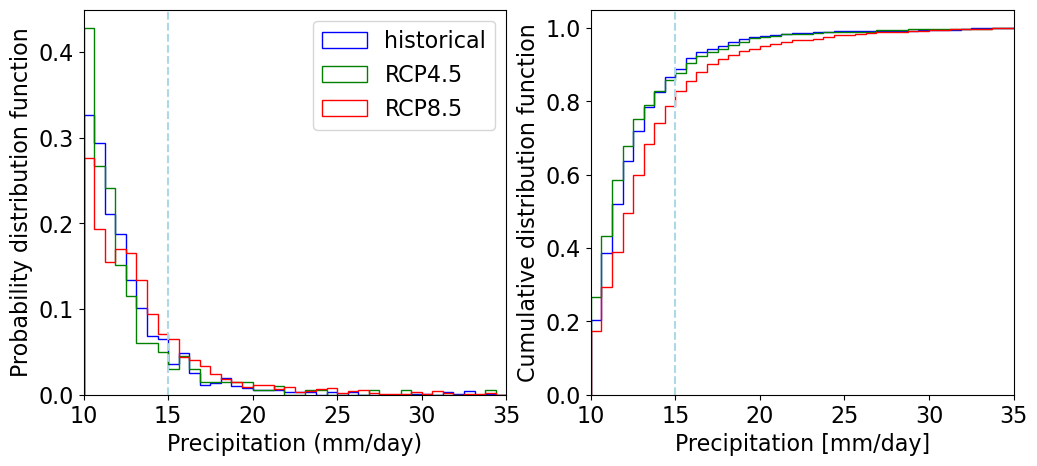

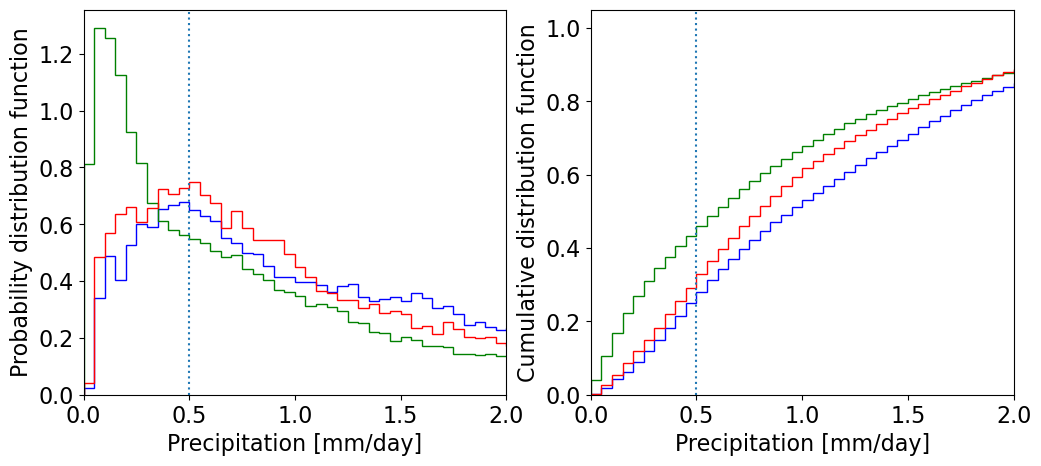

In [50]:
pplot.high_precip(df_ff)
plt.savefig('ff_high_precip.pdf', bbox_inches='tight')

pplot.low_precip(df_ff)
plt.savefig('ff_low_precip.pdf', bbox_inches='tight')

##

## Near-Future Predictions

### RCP8.5

In [92]:
rcp85_nf_rcm_list = []

for file in glob.glob('/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/rcp85*65.csv'):
    print(file)
    df = pd.read_csv(file, index_col=0)
    loc_df =  df

    loc_df['time'] = pd.to_datetime(loc_df['time'])
    loc_df['month'] = loc_df['time'].dt.month
    loc_df = loc_df.sort_values(by=['month', 'lon', 'lat'])
    
    loc_df['tp_scale'] = loc_df['tp']
    
    loc_df_gr = loc_df.groupby(['month', 'lon', 'lat']).mean().reset_index()
    rcp85_nf_rcm_list.append(loc_df_gr[['month', 'lon', 'lat', 'tp_scale']].values.reshape(12, 90, 40, 4))

/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/rcp85_CSIRO_2036_2065.csv
/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/rcp85_NOAA_SMHI_2036_2065.csv
/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/rcp85_MPI-REMO2009_2036_2065.csv
/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/rcp85_MPI_IITM_2036_2065.csv
/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/rcp85_MIROC_2036_2065.csv


In [93]:
rcp85_nf_stack = np.stack(rcp85_nf_rcm_list, axis=0)

In [94]:
mix_exp_rcp85_nf = mixture_of_experts(weights, rcp85_nf_stack[:,:,:,:, 3])

In [95]:
np.save('rcp85_nf_mix_exp_T8.npy', mix_exp_rcp85_nf)

In [96]:
rcp85_nf_ds = xr.Dataset(data_vars=dict(y_pred=(["time", "lon", "lat"], mix_exp_rcp85_nf)),
                           coords=dict(lon =('lon', np.arange(60.25, 105, 0.5)),
                                        lat =('lat', np.arange(20.25, 40, 0.5)),
                                        time = ('time', np.arange(1, 13, 1))))
rcp85_nf_ds

<xarray.Dataset>
Dimensions:  (time: 12, lon: 90, lat: 40)
Coordinates:
  * lon      (lon) float64 60.25 60.75 61.25 61.75 ... 103.2 103.8 104.2 104.8
  * lat      (lat) float64 20.25 20.75 21.25 21.75 ... 38.25 38.75 39.25 39.75
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    y_pred   (time, lon, lat) float64 0.1906 0.1923 0.2045 ... 0.2037 0.1924

### RCP 4.5

In [97]:
rcp45_nf_rcm_list = []

for file in glob.glob('/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/rcp45*65.csv'):
    print(file)
    df = pd.read_csv(file, index_col=0)
    loc_df =  df

    loc_df['time'] = pd.to_datetime(loc_df['time'])
    loc_df['month'] = loc_df['time'].dt.month
    loc_df = loc_df.sort_values(by=['month', 'lon', 'lat'])
    
    loc_df['tp_scale'] = loc_df['tp']
    
    loc_df_gr = loc_df.groupby(['month', 'lon', 'lat']).mean().reset_index()
    rcp45_nf_rcm_list .append(loc_df_gr[['month', 'lon', 'lat', 'tp_scale']].values.reshape(12, 90, 40, 4))

/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/rcp45_MIROC_2036_2065.csv
/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/rcp45_MPI-REMO2009_2036_2065.csv
/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/rcp45_NOAA_SMHI_2036_2065.csv
/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/rcp45_MPI_IITM_2036_2065.csv
/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/rcp45_CSIRO_2036_2065.csv


In [98]:
rcp45_nf_stack = np.stack(rcp45_nf_rcm_list, axis=0)

In [99]:
mix_exp_rcp45_nf = mixture_of_experts(weights, rcp45_nf_stack[:,:,:,:, 3])

In [100]:
np.save('rcp45_nf_mix_exp_T8.npy', mix_exp_rcp45_nf)

In [101]:
rcp45_nf_ds = xr.Dataset(data_vars=dict(y_pred=(["time", "lon", "lat"], mix_exp_rcp45_nf)),
                           coords=dict(lon =('lon', np.arange(60.25, 105, 0.5)),
                                        lat =('lat', np.arange(20.25, 40, 0.5)),
                                        time = ('time', np.arange(1, 13, 1))))
rcp45_nf_ds

<xarray.Dataset>
Dimensions:  (time: 12, lon: 90, lat: 40)
Coordinates:
  * lon      (lon) float64 60.25 60.75 61.25 61.75 ... 103.2 103.8 104.2 104.8
  * lat      (lat) float64 20.25 20.75 21.25 21.75 ... 38.25 38.75 39.25 39.75
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    y_pred   (time, lon, lat) float64 0.1375 0.1465 0.1356 ... 0.06008 0.06555

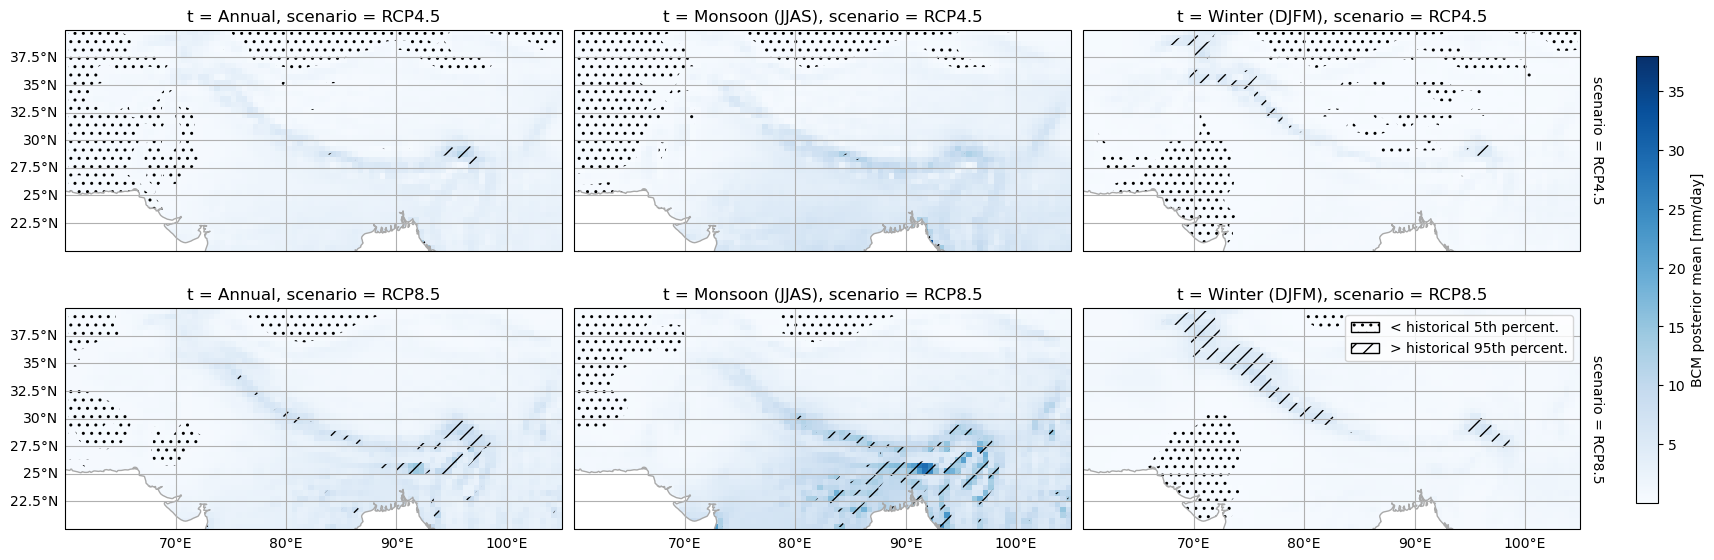

In [102]:
aplot.scenario_plot(historical_ds, rcp45_nf_ds, rcp85_nf_ds)
plt.savefig('scenario_nf_difference.pdf', bbox_inches='tight')

In [103]:
ds_nf = xr.concat([historical_ds, rcp45_nf_ds, rcp85_nf_ds], dim='scenario')
df_nf = ds_nf.to_dataframe()
df_nf = df_nf.unstack('scenario')
df_nf.columns = df_nf.columns.droplevel(0)
df_nf.reset_index(inplace=True)
df_nf.rename(columns={0:'historical', 1:'RCP4.5', 2:'RCP8.5'}, inplace=True)
df_nf

scenario,time,lon,lat,historical,RCP4.5,RCP8.5
0,1,60.25,20.25,0.323148,0.137502,0.190600
1,1,60.25,20.75,0.260154,0.146507,0.192285
2,1,60.25,21.25,0.251318,0.135555,0.204459
3,1,60.25,21.75,0.218724,0.118126,0.229222
4,1,60.25,22.25,0.185323,0.134468,0.228535
...,...,...,...,...,...,...
43195,12,104.75,37.75,0.235142,0.079893,0.227121
43196,12,104.75,38.25,0.239123,0.077467,0.226324
43197,12,104.75,38.75,0.229534,0.072866,0.219894
43198,12,104.75,39.25,0.234260,0.060076,0.203747


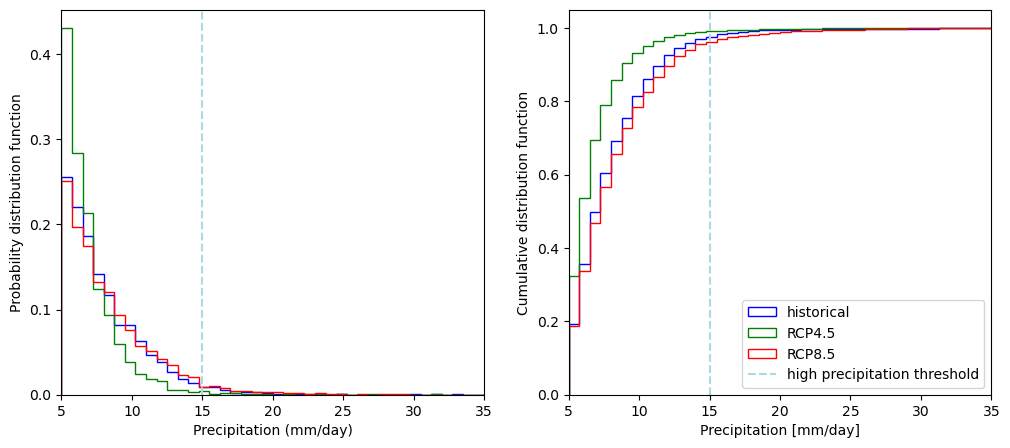

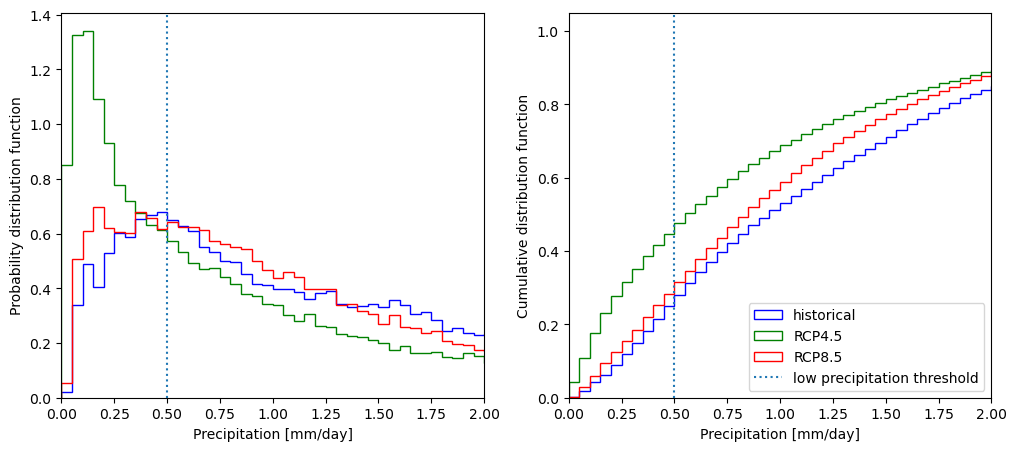

In [105]:
pplot.high_precip(df_nf)
plt.savefig('nf_high_precip.pdf', bbox_inches='tight')

pplot.low_precip(df_nf)
plt.savefig('nf_low_precip.pdf', bbox_inches='tight')